<h2>Installation

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


<h2>Downloads

In [1]:
cezanne = False
ukiyoe = False
vangogh = True
monet = False

In [2]:
if ukiyoe:
  !gdown 11_SJjNxXAGnE_Ufl0_aSS8hFrPueuP1B # ukiyoe2photo
  !unzip /content/ukiyoe2photo.zip
  path = '/content/ukiyoe2photo'

if vangogh:
  !gdown 1dGiEegPdOozA70mknOWBiLk4Ei0Jo88L # vangogh2photo
  !unzip /content/vangogh2photo.zip
  path = '/content/vangogh2photo'

if monet:
  !gdown 1FCHloo_Gn8SUa55hAs5ZLpNIVgdZP_RG # monet2photo
  !unzip /content/monet2photo.zip
  path = '/content/monet2photo'

if cezanne:
  !gdown 1yp4VvEMxnTfYlYR3H2mdJkan_hBhK4-L # cezanne2photo
  !unzip /content/cezanne2photo.zip
  path = '/content/cezanne2photo'

Downloading...
From: https://drive.google.com/uc?id=1dGiEegPdOozA70mknOWBiLk4Ei0Jo88L
To: /content/vangogh2photo.zip
100% 307M/307M [00:03<00:00, 85.7MB/s]
Archive:  /content/vangogh2photo.zip
replace vangogh2photo/trainA/00311.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
!gdown 1DNIpld6ALPRK_phwyimXFT2CieXIsVXZ  # Networks.py
!gdown 1L4ONt4F_cH9bJk-xn1caVPaj9iRF7OPr # train.py
!gdown 1FX8RufFHPtREiiVjD3RQ5LjVhxgbRsVc # utility.py

Downloading...
From: https://drive.google.com/uc?id=1DNIpld6ALPRK_phwyimXFT2CieXIsVXZ
To: /content/networks.py
100% 4.53k/4.53k [00:00<00:00, 7.92MB/s]
Downloading...
From: https://drive.google.com/uc?id=1L4ONt4F_cH9bJk-xn1caVPaj9iRF7OPr
To: /content/train.py
100% 1.94k/1.94k [00:00<00:00, 3.58MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FX8RufFHPtREiiVjD3RQ5LjVhxgbRsVc
To: /content/utility.py
100% 1.72k/1.72k [00:00<00:00, 3.16MB/s]


<h2>Imports

In [4]:
import os
import time
import glob
import torch
import random
import itertools
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from torch import nn, optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from networks import Generator, Discriminator
from utility import show_validation_images, Buffer
from train import init_weights, DATASET, Scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

<h2>Generator

<h2>Initial Setting

In [5]:
# Image
img_height = 256
img_width = 256
channels = 3

# Training
max_epochs = 5 
lr = 0.0002
b1 = 0.5
b2 = 0.999
decay_epoch = 2
# suggested decay_epoch : 100 & suggested max_epochs is 200 in the paper

<h2>Dataset

In [6]:
transform = transforms.Compose([
                transforms.Resize(int(img_height*1.12), Image.BICUBIC),
                transforms.RandomCrop((img_height, img_width)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
dataset = DATASET(path=path, transform = transform, train = True, random = True)
train_loader = DataLoader(dataset, batch_size=4, num_workers=0, shuffle=True)

dataset = DATASET(path=path, transform = transform, train = False, random = True)
val_loader = DataLoader(dataset, batch_size=5, num_workers=0, shuffle=True)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [7]:
print("Number of batches : ", len(train_loader), len(val_loader))
print("Number of datapoints : ", len(train_loader.dataset), len(val_loader.dataset))

Number of batches :  100 10
Number of datapoints :  400 50


<h2>Training

In [8]:
G_AB = Generator()
G_AB.to(device)
D_A = Discriminator() 
D_A.to(device)   
G_BA = Generator()
G_BA.to(device)
D_B = Discriminator() 
D_B.to(device)   
print('Loaded model onto GPU.') 

Loaded model onto GPU.


In [9]:
G_AB.apply(init_weights)
D_A.apply(init_weights)
G_BA.apply(init_weights)
D_B.apply(init_weights)

Discriminator(
  (model): Sequential(
    (0): DiscriminatorBlock(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): DiscriminatorBlock(
      (model): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (2): DiscriminatorBlock(
      (model): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (3): DiscriminatorBlock(
      (model): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
       

In [10]:
criterion_identity = nn.L1Loss()
criterion_cycle = nn.L1Loss()
criterion_GAN = nn.MSELoss()

criterion_GAN.to(device)   
criterion_cycle.to(device)   
criterion_identity.to(device)   

print('Loaded Losses onto GPU.') 

Loaded Losses onto GPU.


In [11]:
optimG = optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr = lr, betas = (b1, b2))
optimD_A = optim.Adam(D_A.parameters(), lr = lr, betas = (b1, b2))
optimD_B = optim.Adam(D_B.parameters(), lr = lr, betas = (b1, b2))

In [12]:
schedulerG = optim.lr_scheduler.LambdaLR(optimG, lr_lambda=Scheduler(max_epochs, decay_epoch).LambdaLr)
schedulerD_A = optim.lr_scheduler.LambdaLR(optimD_A, lr_lambda=Scheduler(max_epochs, decay_epoch).LambdaLr)
schedulerD_B = optim.lr_scheduler.LambdaLR(optimD_B, lr_lambda=Scheduler(max_epochs, decay_epoch).LambdaLr)

In [13]:
fake_A_Buffer = Buffer(50)
fake_B_Buffer = Buffer(50)

Epoch:  1  LR:  0.0002


  0%|          | 0/100 [00:00<?, ?it/s]

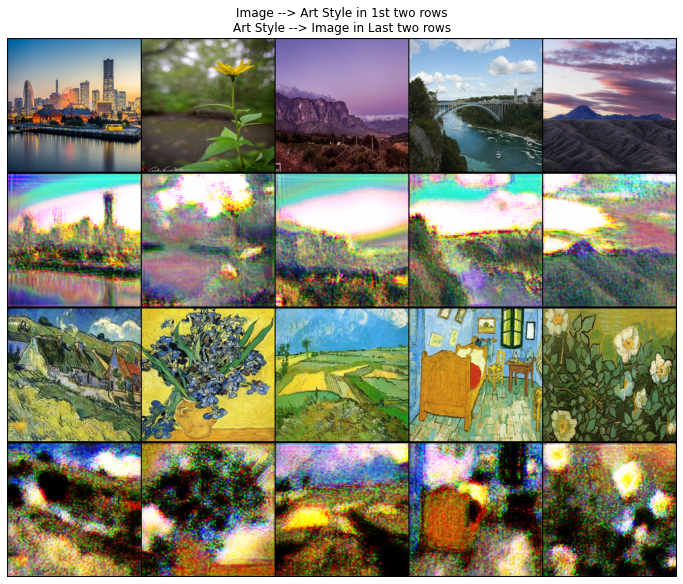

[Epoch 1 / 5] [Batch 20 / 100] [D loss : 23.0771541595459] [G loss : 6.060060501098633 - (adv Loss : 0.8024880886077881, cycle : 0.3799488842487335, identity : 0.3538734018802643)]


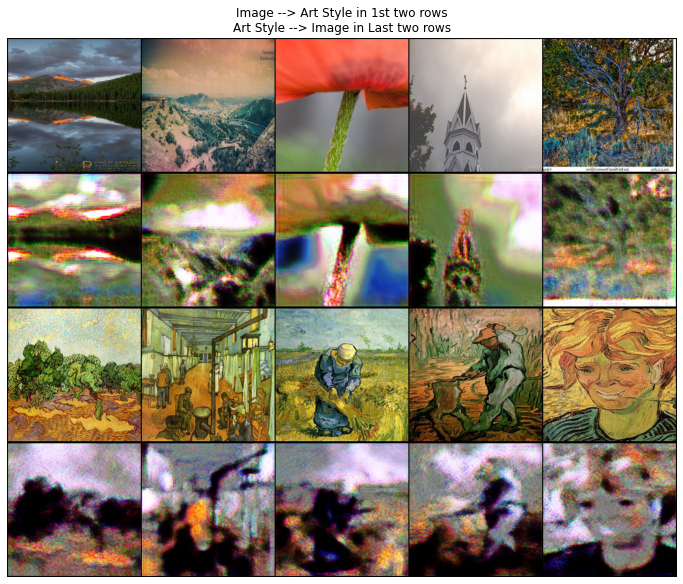

[Epoch 1 / 5] [Batch 40 / 100] [D loss : 16.294544219970703] [G loss : 4.994228363037109 - (adv Loss : 0.4369504451751709, cycle : 0.3528651297092438, identity : 0.32435154914855957)]


In [ ]:
LR = []
for epoch in range(max_epochs):

  print('Epoch: ', epoch + 1,' LR: ', schedulerG.get_last_lr()[0])
  LR += [schedulerG.get_last_lr()]

  for i, batch in enumerate(tqdm(train_loader)):
    A, B = batch['A'].to(device), batch['B'].to(device)
    real = torch.ones(A.shape[0], 1, 16, 16).to(device) # Real Vector for Discriminator
    fake = torch.zeros(A.shape[0], 1, 16, 16).to(device) # Fake Vector for Discriminator
    
    # Training Generator 
    D_A.eval()
    D_B.eval()
    G_AB.train()
    G_BA.train()

    optimG.zero_grad() 

    f_B = G_AB(A) # Fake A
    f_A = G_BA(B) # Fake B

    L_GAN = (criterion_GAN(D_B(f_B), real) + criterion_GAN(D_A(f_A), real)) * 0.5
    L_identity = (criterion_identity(G_AB(B), B) + criterion_identity(G_BA(A), A)) * 0.5
    L_cycle = (criterion_cycle(G_AB(f_A), B)+ criterion_cycle(G_BA(f_B), A)) * 0.5

    Loss_G = 2 * L_GAN + 4 * L_identity + 8 * L_cycle
    Loss_G.backward()
    optimG.step()

    # Traing Discriminator
    D_A.train()
    D_B.train()

    # Training Discriminator A
    optimD_A.zero_grad()
    f_A = fake_A_Buffer.get_and_post(f_A)
    Loss_D_A = (criterion_GAN(D_A(A), real) + criterion_GAN(D_A(f_A.detach()), fake)) * 0.33
    Loss_D_A.backward()
    optimD_A.step()

    # Traing Discriminator B
    optimD_B.zero_grad()
    f_B = fake_B_Buffer.get_and_post(f_B)
    Loss_D_B = (criterion_GAN(D_B(B), real) + criterion_GAN(D_B(f_B.detach()), fake)) * 33
    Loss_D_B.backward()
    optimD_B.step()

    Loss_D = (Loss_D_A + Loss_D_B) * 0.5

    if (i+1) % 20 == 0:
      show_validation_images(val_loader, G_AB, G_BA, device)
      print(f'''[Epoch {epoch + 1} / {max_epochs}] [Batch {i + 1} / {len(train_loader)}] [D loss : {Loss_D.item()}] [G loss : {Loss_G.item()} - (adv Loss : {L_GAN.item()}, cycle : {L_cycle.item()}, identity : {L_identity.item()})]''')

  schedulerG.step()
  schedulerD_A.step()
  schedulerD_B.step()

In [ ]:
filename = 'photo2vangogh.pt'
torch.save(G_AB.state_dict(), filename)